# Imports and Motivation

In order to capture more complex hypothesis, addition of non-linear terms in Logistic Regression based Classification quickly falls short with data containing higher number of features, since the number of terms in the hypothesis will grow asymptotically with an order of **O(n<sup>2</sup>)**

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np
import pandas as pd

# Optimization module in scipy
from scipy import optimize

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "Serif"

# Problem 1

We start the exercise by first loading the dataset. 

In [2]:
DATA_DIR = os.path.join(os.getcwd(), 'data')
SAVE_DIR = os.path.join(os.getcwd(), 'plots')

In [3]:
#  training data stored in arrays X, y
data = pd.read_csv(os.path.join(DATA_DIR,'fashion-mnist_train.csv'))
X,y = data.iloc[:, 1:], data.iloc[:, 0].ravel()
m, nx = X.shape
print("Number of training examples: ", m)
print("Number of features: ", nx)
print("X shape: ", X.shape)
print("y shape: ", y.shape)

Number of training examples:  10000
Number of features:  784
X shape:  (10000, 784)
y shape:  (10000,)


## Visualizing the data

There are 10000 training examples in `fashion-mnist_train`, where each training example is a 28 pixel by 28 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 28 by 28 grid of pixels is “unrolled” into a 784-dimensional vector. Each
of these training examples becomes a single row in our data matrix $X$. This gives us a 10000 by 784 matrix $X$ where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \left(x^{(1)} \right)^T - \\
- \left(x^{(2)} \right)^T - \\
\vdots \\
- \left(x^{(m)} \right)^T - \\
\end{bmatrix}
$$

The second part of the training set is a 10000-dimensional vector `y` that contains labels for the training set. 
The following cell randomly selects 100 images from the dataset and plots them.

In [4]:
# Create dictionary of target classes
label_dict = {
0: r"T-shirt",
1: "Trouser",
2: "Pullover",
3: "Dress",
4: "Coat",
5: "Sandal",
6: "Shirt",
7: "Sneaker",
8: "Bag",
9: "Boot"
}

In [5]:
# Randomly select 100 data points to display
# rand_indices = np.random.choice(X.shape[0], 100, replace=False)
# sel = X.iloc[rand_indices, :]
# y_sample = y[rand_indices]

# ax, fig = plt.subplots(figsize=(15, 15))

# for i in range(10):
#     for j in range(10):
#         ax = plt.subplot(10, 10, i*10+j+1)
#         ax.imshow(sel.iloc[i*10+j, :].values.reshape(28, 28), cmap='binary')
#         ax.axis('off')
#         ax.set_title(label_dict[y_sample[i*10+j]])
# plt.tight_layout()
# plt.savefig(os.path.join(SAVE_DIR, '0101.png'))
# plt.show()

## Normalizing

In [6]:
def scale_one(col, df):
    minimum = df[col].min()
    maximum = df[col].max()
    return (df[col]-minimum)/(maximum-minimum)

In [7]:
cols = X.columns
for col in cols:
    X[col] = scale_one(col, X)

/tmp/ipykernel_17972/143795211.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = scale_one(col, X)


## Train  Test

In [8]:
X = X.values

In [9]:
np.random.seed(42)
ratio = 0.7
ids = np.arange(X.shape[0])
np.random.shuffle(ids)
train_ids = ids[:int(ratio * X.shape[0])]
test_ids = ids[int(ratio * X.shape[0]):]
X_train, y_train = X[train_ids], y[train_ids]
X_test, y_test = X[test_ids], y[test_ids]
assert len(X_train) + len(X_test) == len(X)
assert len(X_train)>len(X_test)

# Problem 2-4

##  Model representation



Our neural network is shown in the following figure.

![](Figures/neural_network.png)

It has 3 layers - an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values
of digit images. Since the images are of size $28 \times 28$, this gives us 784 nput layer units (not counting the extra bias unit which always outputs +1). The training data was loaded into the variables `X` and `y` above.


In [10]:
# Setup the parameters you will use for this exercise
input_layer_size  = 28*28  # 20x20 Input Images of Digits
hidden_layer_size = 25  # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9


w1 = np.random.rand(hidden_layer_size, input_layer_size+1)
w2 = np.random.rand(num_labels, hidden_layer_size+1)

assert w1.shape == (hidden_layer_size, input_layer_size+1)
assert w2.shape == (num_labels, hidden_layer_size+1)

#unroll parameters
nn_params = np.concatenate((w1.ravel(), w2.ravel()), axis=0)
assert nn_params.shape == (hidden_layer_size * (input_layer_size + 1) + num_labels * (hidden_layer_size + 1),)

## 1.3 Feedforward Propagation and Prediction

Now you will implement feedforward propagation for the neural network. You will need to complete the code in the function
`predict` to return the neural network’s prediction. You should implement the feedforward computation that computes
$h_\theta(x^{(i)})$ for every example $i$ and returns the associated predictions. Similar to the one-vs-all classification
strategy, the prediction from the neural network will be the label that has the largest output $\left( h_\theta(x) \right)_k$.

The predict function is provided way below!

## Feedforward Method

### Activation Function

Here, we define the activation function to be the sigmoid function. The sigmoid function is defined as:

$$
g(z) = \frac{1}{1+e^{-z}}
$$

We also define the derivative of the sigmoid function as:

$$
g'(z) = g(z)(1-g(z))
$$

We need to work with relu too. The relu function is defined as:

$$
g(z) = max(0,z)
$$

We also define the derivative of the relu function as:

$$
g'(z) = 1(z>0)
$$

In [11]:
def sigmoid(z):
    """
    Compute the sigmoid function.
    
    Parameters
    ----------
    z : array_like
        The input value. If it's a vector or matrix, the function is
        applied element-wise.
    
    Return
    ------
    g : array_like
        The value of the sigmoid function at each point of z.
    """
    g = 1 / (1 + np.exp(-z ))
    return g

def sigmoidGradient(z):
    """
    Compute the gradient of the sigmoid function evaluated at z.
    
    Parameters
    ----------
    z : array_like
        The input value. If it's a vector or matrix, the function is
        applied element-wise.
    
    Return
    ------
    g : array_like
        The value of the sigmoid gradient function at each point of z.
    """
    g = sigmoid(z) * (1 - sigmoid(z))
    return g


def relu(z):
    """
    Compute the relu function.
    
    Parameters
    ----------
    z : array_like
        The input value. If it's a vector or matrix, the function is
        applied element-wise.
    
    Return
    ------
    g : array_like
        The value of the relu function at each point of z.
    """
    g = np.maximum(0, z)
    return g

def reluGradient(z):
    """
    Compute the gradient of the relu function evaluated at z.
    
    Parameters
    ----------
    z : array_like
        The input value. If it's a vector or matrix, the function is
        applied element-wise.
    
    Return
    ------
    g : array_like
        The value of the relu gradient function at each point of z.
    """
    g = np.where(z > 0, 1, 0)
    return g

### The Forward Pass

Here, we'll create a function that will take in the input data and the weights and biases of the network and return the output of the network. The function will be called `forward_pass`.

In [12]:
def forward_pass(X, w1, w2, activation="sigmoid"):
    """
    Calculate the forward pass of the neural network.

    Parameters
    ----------
    X : array_like
        The image inputs having shape (number of examples x image dimensions).
    w1 : array_like
        Weights for the first layer in the neural network.
        It has shape (2nd hidden layer size x input size)
    w2: array_like
        Weights for the second layer in the neural network.
        It has shape (output layer size x 2nd hidden layer size)
    activation : str
        The activation function to use in the hidden layer.
        It can be either "sigmoid" or "relu".
    
    Return
    ------
    A2 : array_like
        The output of the neural network.
    """
    Z1 = np.dot(w1, X.T)
    if activation == "sigmoid":
        A1 = sigmoid(Z1)
    elif activation == "relu":
        A1 = relu(Z1)
    else:
        raise ValueError("Activation function not supported.")
    Z2 = np.dot(w2, A1)
    A2 = sigmoid(Z2)
    return Z1, A1, Z2, A2

### Unregularized Cost Function

Now you will implement the cost function and gradient for the neural network.

Recall that the cost function for the neural network (without regularization) is:

$$ J(w) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_w \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_w \left( x^{(i)} \right) \right)_k \right) \right]$$

where $h_w \left( x^{(i)} \right)$ is computed as shown in the neural network figure above, and K = 10 is the total number of possible labels. Note that $h_w(x^{(i)})_k = a_k^{(3)}$ is the activation (output
value) of the $k^{th}$ output unit. Also, recall that whereas the original labels (in the variable y) were 0, 1, ..., 9, for the purpose of training a neural network, we need to encode the labels as vectors containing only values 0 or 1, so that

$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.

You should implement the feedforward computation that computes $h_w(x^{(i)})$ for every example $i$ and sum the cost over all examples. **Your code should also work for a dataset of any size, with any number of labels** (you can assume that there are always at least $K \ge 3$ labels).

### Regularized cost function

The cost function for neural networks with regularization is given by:


$$ J(w) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_w \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_w \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{l=1}^{L-1} \sum_{i=1}^{S_{l}} \sum_{j=1}^{S_{l+1}} \left( w_{ji}^{(l)} \right)^2 \right] $$

Note that the terms corresponding to the bias should not be regularized. For the matrices `w1` and `w2`, this corresponds to the first column of each matrix. You should now add regularization to your cost function.

While calculating the loss, the $\hat{y}$ which we will get from the forward pass will be a matrix of size $m \times K$. We will need to convert the true labels `y` to a matrix of size $m \times K$ as well. This can be done using the `one_hot` function define below:

In [13]:
def one_hot(y, num_labels=10):
    """
    Convert the target vector into a one-hot encoded matrix.
    
    Parameters
    ----------
    y : array_like
        The target vector having shape (number of examples x 1).
    
    Return
    ------
    y_onehot : array_like
        The one-hot encoded matrix having shape (number of examples x number of classes).
    """
    m = y.shape[0]
    y_onehot = np.zeros((m, num_labels))
    for i in range(m):
        y_onehot[i, y[i]] = 1
    return y_onehot

In [14]:
# Setup the parameters you will use for this exercise
input_layer_size  = 28*28  # 20x20 Input Images of Digits
hidden_layer_size = 25  # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9


w1 = np.random.rand(hidden_layer_size, input_layer_size)
w2 = np.random.rand(num_labels, hidden_layer_size)

assert w1.shape == (hidden_layer_size, input_layer_size)
assert w2.shape == (num_labels, hidden_layer_size)

#unroll parameters
nn_params = np.concatenate((w1.ravel(), w2.ravel()), axis=0)
assert nn_params.shape == (hidden_layer_size * (input_layer_size) + num_labels * (hidden_layer_size),)

In [15]:
forward_pass(X, w1, w2, activation="sigmoid")[0].shape

(25, 10000)

The calculation of cost function will be provided much below.

## Backpropagation- A brief introduction.

Backpropagation is the heart of every neural network. Firstly, we need to make a distinction between backpropagation and optimizers.

Backpropagation is for calculating the gradients efficiently, while optimizers is for training the neural network, using the gradients computed with backpropagation. In short, all backpropagation does for us is compute the gradients. Nothing more.

### How does it work

We always start from the output layer and propagate backwards, updating weights and biases for each layer.

The idea is simple: adjust the weights and biases throughout the network, so that we get the desired output in the output layer. Say we wanted the output neuron to be 1.0, then we would need to nudge the weights and biases so that we get an output closer to 1.0.

We can only change the weights and biases, but activations are direct calculations of those weights and biases, which means we indirectly can adjust every part of the neural network, to get the desired output — except for the input layer, since that is the dataset that you input.

### Computing Gradients

Firstly, let's start by defining the relevant equations. Note that any indexing explained earlier is left out here, and we abstract to each layer instead of each weight, bias or activation:

\begin{equation}
z^{(L)}=w^{(L)} \times x +b \newline
a^{(L)}=
    g\left(
    \boldsymbol{z}^{(L)}
    \right) \newline
    C=(a^{(L)}-y)^2
\end{equation}


The **gradient** of this Cost Function C in the backpropagation algorithm, can be then be thought of as the change  in the cost function in relation to a specific weight. Therefore the change of Cost Function with respect to weights w can be best captured by:

\begin{equation}
\frac{\partial C}{\partial w^{(L)}}
    =
    \frac{\partial C}{\partial a^{(L)}}
    \frac{\partial a^{(L)}}{\partial z^{(L)}}
    \frac{\partial z^{(L)}}{\partial w^{(L)}}
    =
    2 \left(a^{(L)} - y \right) \sigma' \left(z^{(L)}\right) x^{(L-1)}
\end{equation}

Then you would update the weights after each mini-batch. Each weight is 'nudged' a certain amount for each layer l
\begin{equation}
w^{(l)} = w^{(l)} - \text{learning rate} \times \frac{\partial C}{\partial w^{(l)}}
\end{equation}

We have to move all the way back through the network and adjust each weight, iteratively.

## Backpropagation Method

In this part of the exercise, you will implement the backpropagation algorithm to compute the gradient for the neural network cost function. You will need to update the function `nnCostFunction` so that it returns an appropriate value for `grad`. Once you have computed the gradient, you will be able to train the neural network by minimizing the cost function $J(w)$ using an advanced optimizer such as `scipy`'s `optimize.minimize`.
You will first implement the backpropagation algorithm to compute the gradients for the parameters for the (unregularized) neural network. After you have verified that your gradient computation for the unregularized case is correct, you will implement the gradient for the regularized neural network.

![](Figures/ex4-backpropagation.png)

<a id="section4"></a>
### Backpropagation

Now, you will implement the backpropagation algorithm. Recall that the intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)}, y^{(t)})$, we will first run a “forward pass” to compute all the activations throughout the network, including the output value of the hypothesis $h_w(x)$. Then, for each node $j$ in layer $l$, we would like to compute an “error term” $\delta_j^{(l)}$ that measures how much that node was “responsible” for any errors in our output.

For an output node, we can directly measure the difference between the network’s activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, you will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l+1)$. In detail, here is the backpropagation algorithm (also depicted in the figure above). You should implement steps 1 to 4 in a loop that processes one example at a time. Concretely, you should implement a for-loop `for t in range(m)` and place steps 1-4 below inside the for-loop, with the $t^{th}$ iteration performing the calculation on the $t^{th}$ training example $(x^{(t)}, y^{(t)})$. Step 5 will divide the accumulated gradients by $m$ to obtain the gradients for the neural network cost function.

1. Set the input layer’s values $(a^{(1)})$ to the $t^{th }$training example $x^{(t)}$. Perform a feedforward pass, computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. Note that you need to add a `+1` term to ensure that the vectors of activations for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit. In `numpy`, if a 1 is a column matrix, adding one corresponds to `a_1 = np.concatenate([np.ones((m, 1)), a_1], axis=1)`.

1. For each output unit $k$ in layer 3 (the output layer), set 
$$\delta_k^{(3)} = \left(a_k^{(3)} - y_k \right)$$
where $y_k \in \{0, 1\}$ indicates whether the current training example belongs to class $k$ $(y_k = 1)$, or if it belongs to a different class $(y_k = 0)$. You may find logical arrays helpful for this task (explained in the previous programming exercise).

1. For the hidden layer $l = 2$, set 
$$ \delta^{(2)} = \left( w^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$
Note that the symbol $*$ performs element wise multiplication in `numpy`.

1. Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta_0^{(2)}$. In `numpy`, removing $\delta_0^{(2)}$ corresponds to `delta_2 = delta_2[1:]`.

1. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$:
$$ \frac{\partial}{\partial w_{ij}^{(l)}} J(w) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$

<a id="section3"></a>
### Sigmoid Gradient



To help you get started with this part of the exercise, you will first implement
the sigmoid gradient function. The gradient for the sigmoid function can be
computed as

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$

where

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

Now complete the implementation of `sigmoidGradient` in the next cell.
<a id="sigmoidGradient"></a>

I've already implemented the sigmoid function's derivative in above cell. Call it `sigmoidGradient` and use it to compute the gradient for the sigmoid function.

### Random Initialization



When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $w^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$. We are going to use $\epsilon_{init} = 0.12$. This range of values ensures that the parameters are kept small and makes the learning more efficient.

Use the function `randInitializeWeights` to initialize the weights for $w$. Note that the function has been provided with an argument for $\epsilon$ with default value `epsilon_init = 0.12`.

In [16]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Randomly initialize the weights of a layer in a neural network.
    
    Parameters
    ----------
    L_in : int : Number of incomming connections.
    
    L_out : int : Number of outgoing connections. 
    
    epsilon_init : float, optional : Range of values which the weight can take from a uniform distribution.
    
    """
    w = np.random.uniform(-epsilon_init, epsilon_init, (L_out, L_in))
    return w

In [17]:
#randomly initialise weights for two different layers
initial_w1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_w2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters into a single array
initial_nn_params = np.concatenate([initial_w1.ravel(), initial_w2.ravel()], axis=0)

In [18]:
initial_w1

array([[-0.03389006,  0.04834438,  0.11473799, ...,  0.01599076,
         0.02824826,  0.04709051],
       [-0.0117641 , -0.037648  ,  0.07210098, ..., -0.05834206,
        -0.05987004, -0.09175405],
       [ 0.08727192,  0.0540141 , -0.03800236, ...,  0.02587131,
         0.11574874, -0.07976538],
       ...,
       [ 0.01434149,  0.11932206,  0.02696369, ..., -0.09799472,
         0.11184685,  0.04699645],
       [-0.07892064,  0.11371973,  0.05178866, ...,  0.07794529,
        -0.08490146, -0.09870449],
       [ 0.0394203 , -0.06952675,  0.06754857, ...,  0.08679093,
         0.05682961,  0.02782519]])

<a id="section5"></a>
### Regularized Neural Network



After you have successfully implemented the backpropagation algorithm, you also need to add regularization to the gradient. To account for regularization, it turns out that you can add this as an additional term *after* computing the gradients using backpropagation.

Specifically, after you have computed $\Delta_{ij}^{(l)}$ using backpropagation, you should add regularization using

$$ \begin{align} 
& \frac{\partial}{\partial w_{ij}^{(l)}} J(w) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} & \qquad \text{for } j = 0 \\
& \frac{\partial}{\partial w_{ij}^{(l)}} J(w) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} w_{ij}^{(l)} & \qquad \text{for } j \ge 1
\end{align}
$$

Note that you should *not* be regularizing the first column of $w^{(l)}$ which is used for the bias term. Furthermore, in the parameters $w_{ij}^{(l)}$, $i$ is indexed starting from 1, and $j$ is indexed starting from 0. Thus, 

$$
w^{(l)} = \begin{bmatrix}
w_{1,0}^{(i)} & w_{1,1}^{(l)} & \cdots \\
w_{2,0}^{(i)} & w_{2,1}^{(l)} & \cdots \\
\vdots &  ~ & \ddots
\end{bmatrix}
$$

In [19]:
def nnCostFunction(
    nn_params,
    input_layer_size,
    hidden_layer_size,
    num_labels,
    X,
    y,
    lambda_=0.0,
    activation="sigmoid",
):
    """
    Implements the neural network cost function and gradient for a two layer neural
    network which performs classification.

    Parameters
    ----------
    nn_params : array_like
        The parameters for the neural network which are "unrolled" into
        a vector.

    input_layer_size : int
        Number of features for the input layer.

    hidden_layer_size : int
        Number of hidden units in the second layer.

    num_labels : int
        Total number of labels, or equivalently number of units in output layer.

    X : array_like
        Input dataset. A matrix of shape (m x input_layer_size).

    y : array_like
        Dataset labels. A vector of shape (m,).

    lambda_ : float, optional
        Regularization parameter.

    Returns
    -------
    J : float : The computed value for the cost function at the current weight values.

    grad : array_like : An "unrolled" vector of the partial derivatives of the concatenatation of
                        neural network weights w1 and w2.
    """

    w1 = np.reshape(
        nn_params[: hidden_layer_size * (input_layer_size)],
        (hidden_layer_size, (input_layer_size)),
    )

    w2 = np.reshape(
        nn_params[(hidden_layer_size * (input_layer_size)) :],
        (num_labels, (hidden_layer_size)),
    )

    # Setup some useful variables
    m = y.size

    # You need to return the following variables correctly
    J = 0
    Z1, A1, Z2, A2 = forward_pass(X, w1, w2, activation=activation)
    y_hat = A2
    y_true = one_hot(y).T
    assert y_hat.shape == y_true.shape
    # calculating loss
    J = -np.sum(
        y_true * np.log(y_hat + 1e-10) + (1 - y_true) * np.log(1 - y_hat + 1e-10)
    )
    # adding regularization
    J += lambda_ * (np.sum(w1**2) + np.sum(w2**2))
    # diving by number of examples
    J = J / (2 * m)

    # Calculating gradients

    delLdelA2 = y_hat - y_true
    if activation == "sigmoid":
        delgdelZ2 = sigmoidGradient(Z2)
    elif activation == "relu":
        delgdelZ2 = reluGradient(Z2)
    delta2 = delLdelA2 * delgdelZ2
    # print(delta2.shape, A1.shape)
    dw2 = np.dot(delta2, A1.T)

    delLdelA1 = np.dot(w2.T, delta2)
    if activation == "sigmoid":
        delgdelZ1 = sigmoidGradient(Z1)
    elif activation == "relu":
        delgdelZ1 = reluGradient(Z1)
    delta1 = delLdelA1 * delgdelZ1
    # print(delta1.shape, X.shape)
    dw1 = np.dot(delta1, X)

    # Unroll gradients
    grad = np.concatenate([dw1.ravel(), dw2.ravel()], axis=0)

    return J, grad

In [20]:
l, delL = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_=0.0)
np.unique(delL)

array([0.00000000e+00, 2.14016252e-23, 2.28083048e-23, ...,
       2.38547237e-01, 2.38547237e-01, 2.38547237e-01])

### Learning parameters using `scipy.optimize.minimize`

After you have successfully implemented the neural network cost function
and gradient computation, the next step we will use `scipy`'s minimization to learn a good set parameters.

Here, we'll write some more functions. A few will be to claculate the metrics and another to make a prediction. Here are the functions:


In [21]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    return np.sum(y_true & y_pred) / np.sum(y_pred)

def recall(y_true, y_pred):
    return np.sum(y_true & y_pred) / np.sum(y_true)

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * p * r / (p + r)

def predict(X, nn_params, activation="sigmoid"):
    """
    Predicts the label of an input given a trained neural network.
    
    Parameters
    ----------
    X : array_like : Input data of size (m x n) where m is the number of examples, and n is the number of features.
    
    nn_params : array_like : Weights for layer 1 of shape (hidden_layer_size x input_layer_size).
    
    
    activation : str, optional : Activation function to be used in the hidden layer. Default is 'sigmoid'.
    
    Returns
    -------
    y_pred : array_like : Predictions for each example in X. A vector of shape (m,).
    
    """
    w1 = np.reshape(
        nn_params[: hidden_layer_size * (input_layer_size)],
        (hidden_layer_size, (input_layer_size)),
    )

    w2 = np.reshape(
        nn_params[(hidden_layer_size * (input_layer_size)) :],
        (num_labels, (hidden_layer_size)),
    )

    Z1, A1, Z2, A2 = forward_pass(X, w1, w2, activation=activation)
    y_pred = np.argmax(A2, axis=0)
    return y_pred

# Problem 3

In [22]:

#  After you have completed the assignment, change the maxiter to a larger value to see how more training helps.
options= {'maxiter': 100}

X = X_train
y = y_train

#  You should also try different values of lambda
lambda_ = 0.1
activation = "relu"

J_history = []
accuracy_history = []
precision_history = []
recall_history = []
f1_history = []
iter = 1
def callbackF(Xi):
    global iter
    h = nnCostFunction(Xi, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_=0.0)[0]
    y_pred = predict(X, Xi, activation=activation)
    acc = accuracy(y, y_pred)
    prec = precision(y, y_pred)
    rec = recall(y, y_pred)
    f1 = f1_score(y, y_pred)
    accuracy_history.append(acc)
    precision_history.append(prec)
    recall_history.append(rec)
    f1_history.append(f1)
    J_history.append(h)

    print(f"Iteration {iter:3d} | Cost {h:.4f} | Accuracy {acc:.4f} | Precision {prec:.4f} | Recall {rec:.4f} | F1 {f1:.4f}")
    iter += 1

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size, # p == nn_param
                                        hidden_layer_size,
                                        num_labels, X, y, lambda_ = lambda_, activation=activation)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        callback=callbackF,
                        # tol=1e-26,
                        options=options)

res_relu = res
J_relu = J_history
accuracy_relu =accuracy_history
precision_relu = precision_history
recall_relu = recall_history
f1_relu = f1_history

Iteration   1 | Cost 3.4774 | Accuracy 0.0859 | Precision 0.2880 | Recall 0.3477 | F1 0.3151


In [23]:
res_relu

     fun: 3.4542365321433057
     jac: array([0.00000000e+00, 2.41534668e-02, 1.21056795e-02, ...,
       1.00970809e+03, 6.38366083e+02, 1.72574617e+02])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 45
     nit: 1
  status: 1
 success: True
       x: array([-0.03389006,  0.04834438,  0.11473799, ..., -0.11613237,
        0.01991371, -0.08712506])

In [24]:

#  After you have completed the assignment, change the maxiter to a larger value to see how more training helps.
options= {'maxiter': 300}
X = X_train
y = y_train
#  You should also try different values of lambda
lambda_ = 0.1
activation = "sigmoid"

J_history = []
accuracy_history = []
precision_history = []
recall_history = []
f1_history = []
iter = 1
def callbackF(Xi):
    global iter
    h = nnCostFunction(Xi, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_=0.0)[0]
    y_pred = predict(X, Xi, activation=activation)
    acc = accuracy(y, y_pred)
    prec = precision(y, y_pred)
    rec = recall(y, y_pred)
    f1 = f1_score(y, y_pred)
    accuracy_history.append(acc)
    precision_history.append(prec)
    recall_history.append(rec)
    f1_history.append(f1)
    J_history.append(h)

    print(f"Iteration {iter:3d} | Cost {h:.4f} | Accuracy {acc:.4f} | Precision {prec:.4f} | Recall {rec:.4f} | F1 {f1:.4f}")
    iter += 1

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size, # p == nn_param
                                        hidden_layer_size,
                                        num_labels, X, y, lambda_ = lambda_, activation=activation)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        callback=callbackF,
                        options=options)

res_sigmoid = res
J_sigmoid = J_history
accuracy_sigmoid =accuracy_history
precision_sigmoid = precision_history
recall_sigmoid = recall_history
f1_sigmoid = f1_history

Iteration   1 | Cost 1.6318 | Accuracy 0.1393 | Precision 0.4918 | Recall 0.3385 | F1 0.4010
Iteration   2 | Cost 1.5649 | Accuracy 0.2767 | Precision 0.4047 | Recall 0.4949 | F1 0.4453
Iteration   3 | Cost 1.4974 | Accuracy 0.4114 | Precision 0.5560 | Recall 0.6119 | F1 0.5826
Iteration   4 | Cost 1.2863 | Accuracy 0.4403 | Precision 0.6201 | Recall 0.7162 | F1 0.6647
Iteration   5 | Cost 1.1281 | Accuracy 0.5290 | Precision 0.7456 | Recall 0.6804 | F1 0.7115
Iteration   6 | Cost 1.0104 | Accuracy 0.5667 | Precision 0.8287 | Recall 0.6361 | F1 0.7197
Iteration   7 | Cost 0.8944 | Accuracy 0.6117 | Precision 0.7897 | Recall 0.7197 | F1 0.7531
Iteration   8 | Cost 0.8192 | Accuracy 0.6556 | Precision 0.8366 | Recall 0.7155 | F1 0.7713
Iteration   9 | Cost 0.7305 | Accuracy 0.7291 | Precision 0.8569 | Recall 0.7969 | F1 0.8258
Iteration  10 | Cost 0.6529 | Accuracy 0.7301 | Precision 0.8646 | Recall 0.7766 | F1 0.8182
Iteration  11 | Cost 0.6133 | Accuracy 0.7711 | Precision 0.8720 | Rec

In [25]:
res_sigmoid

     fun: 0.31261568133300366
     jac: array([-5.36852959e-09, -1.52384044e-08, -8.70339093e-05, ...,
       -5.75233508e-02, -2.56527238e-01,  5.18461916e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 301
     nit: 23
  status: 3
 success: False
       x: array([-0.03390454,  0.04878946,  0.12093554, ..., -2.80239989,
       -0.84614716,  2.12620712])

In [26]:
w_relu = res_relu.x
w_sigmoid = res_sigmoid.x


# Problem 4

In [27]:
relu_test_accuracy = accuracy(y_test, predict(X_test, w_relu, "relu"))
sigmoid_test_accuracy = accuracy(y_test, predict(X_test, w_sigmoid, "sigmoid"))
print("Relu Accuracy", relu_test_accuracy)
print("Sigmoid Accuracy", sigmoid_test_accuracy)

Relu Accuracy 0.08533333333333333
Sigmoid Accuracy 0.836


# Problem 5

/tmp/ipykernel_17972/301730126.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(10, 10, i*10+j+1)


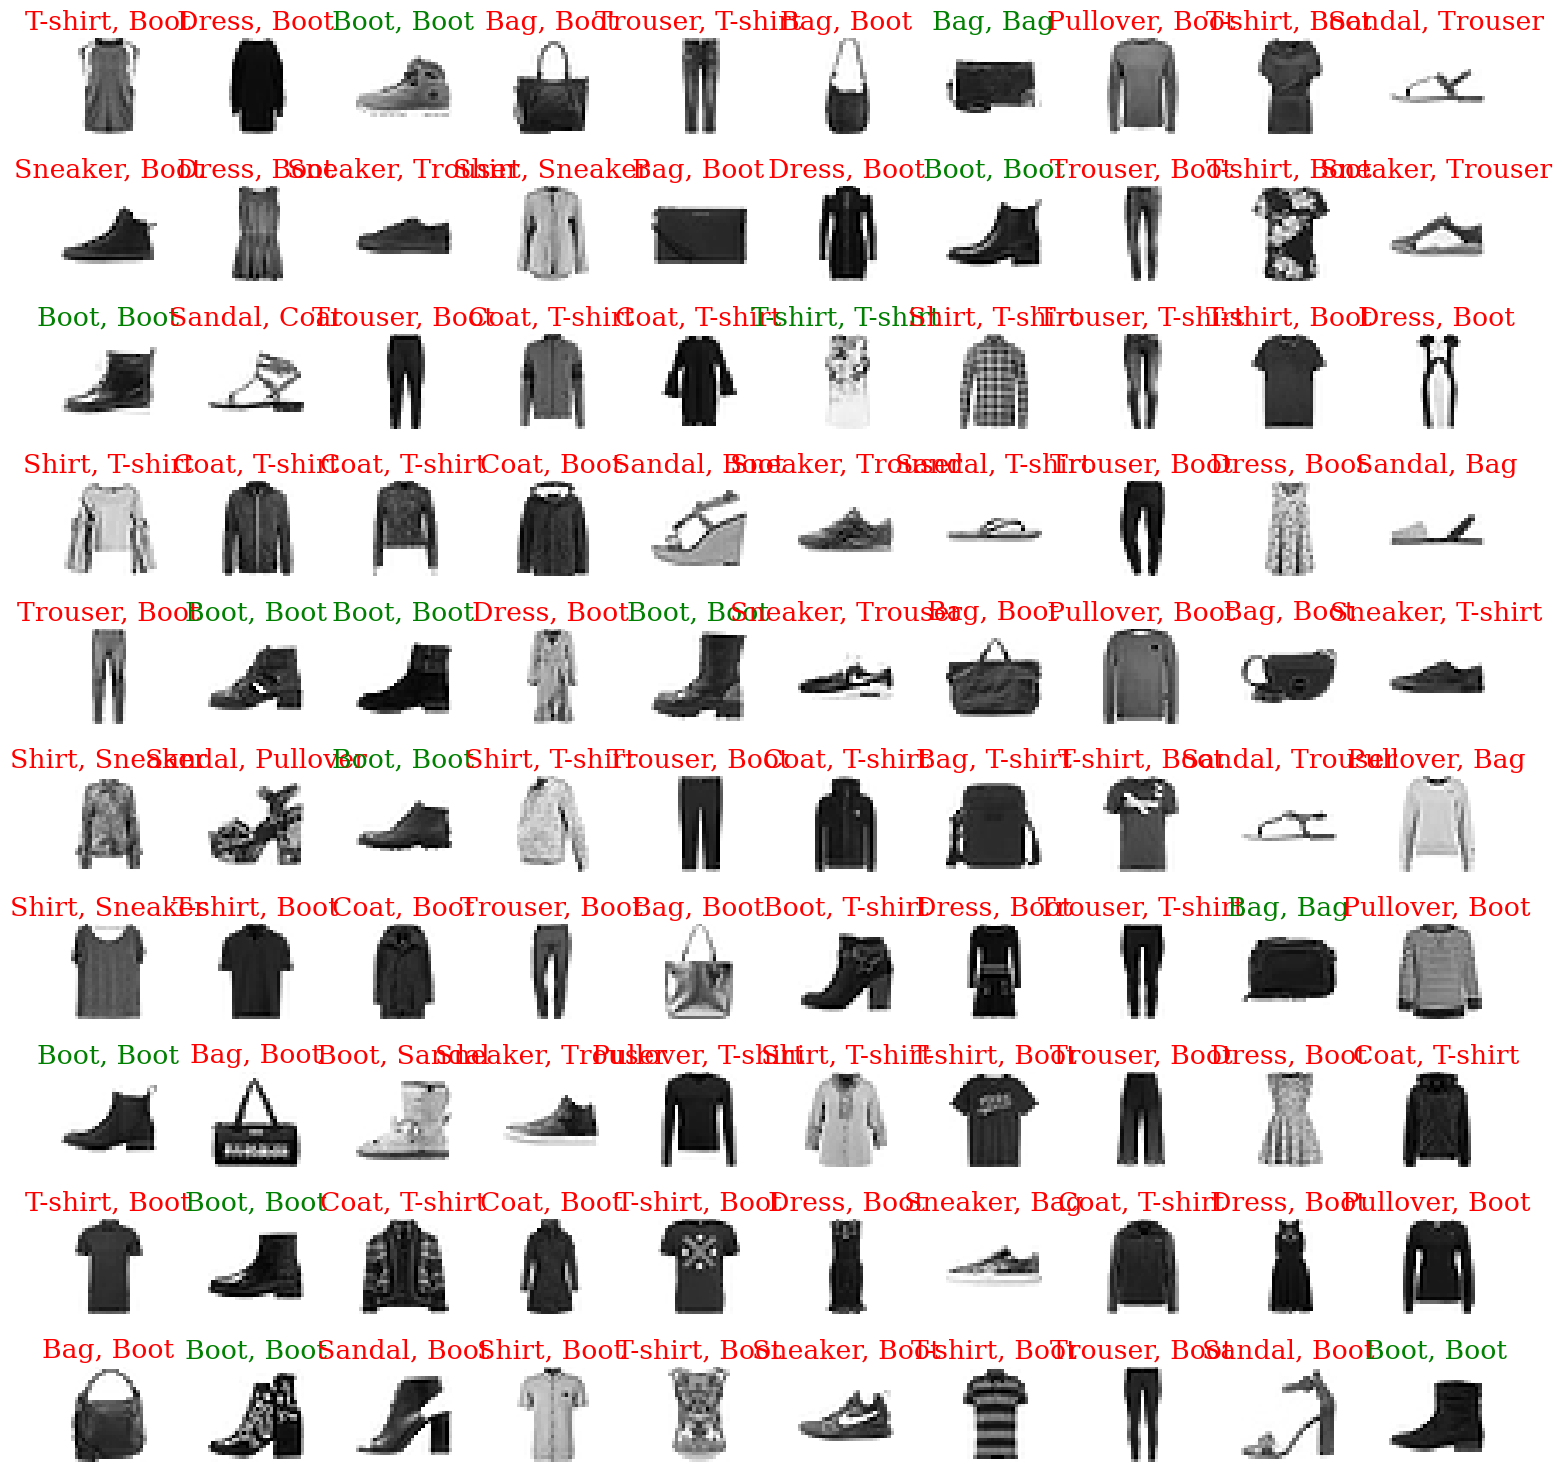

In [28]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(X_test.shape[0], 100, replace=False)
sample = X[rand_indices, :]
y_sample = y[rand_indices]
y_pred = predict(sample, w_relu, "relu")
ax, fig = plt.subplots(figsize=(15, 15))

for i in range(10):
    for j in range(10):
        ax = plt.subplot(10, 10, i*10+j+1)
        ax.imshow(sample[i*10+j, :].reshape(28, 28), cmap='binary')
        ax.axis('off')
        true_label = label_dict[y_sample[i*10+j]]
        pred_label = label_dict[y_pred[i*10+j]]
        if true_label==pred_label:
            color = "green"
        else:
            color = "red"
        ax.set_title(f"{true_label}, {pred_label}", fontdict={
            "color": color
        })
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, '0501.png'))
plt.show()

/tmp/ipykernel_17972/2141869875.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(10, 10, i*10+j+1)


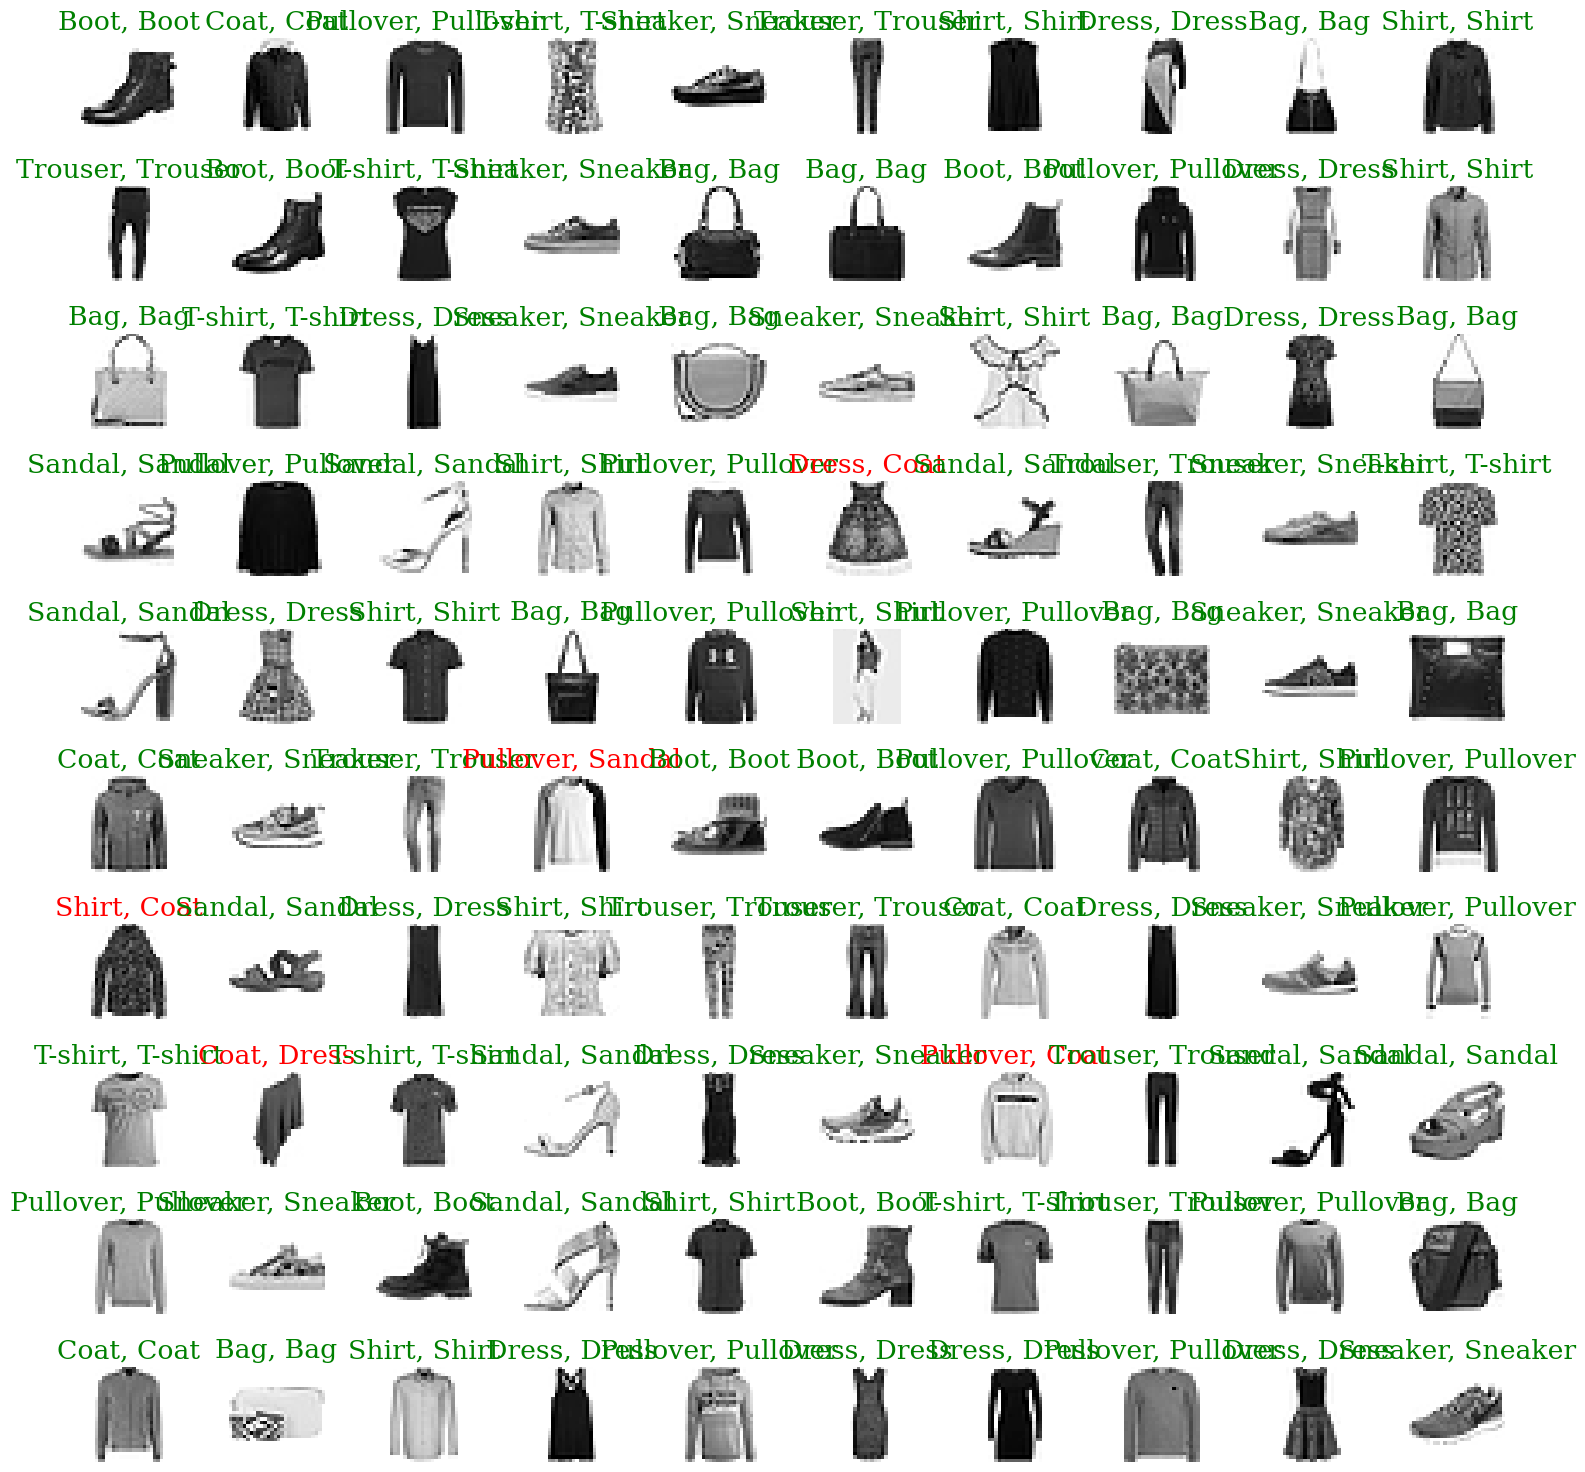

In [29]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(X_test.shape[0], 100, replace=False)
sample = X[rand_indices, :]
y_sample = y[rand_indices]
y_pred = predict(sample, w_sigmoid, "sigmoid")
ax, fig = plt.subplots(figsize=(15, 15))

for i in range(10):
    for j in range(10):
        ax = plt.subplot(10, 10, i*10+j+1)
        ax.imshow(sample[i*10+j, :].reshape(28, 28), cmap='binary')
        ax.axis('off')
        true_label = label_dict[y_sample[i*10+j]]
        pred_label = label_dict[y_pred[i*10+j]]
        if true_label==pred_label:
            color = "green"
        else:
            color = "red"
        ax.set_title(f"{true_label}, {pred_label}", fontdict={
            "color": color
        })
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, '0502.png'))
plt.show()

# Problem 6

The relu is having some trouble. Softmax is good though!

# Problem 7

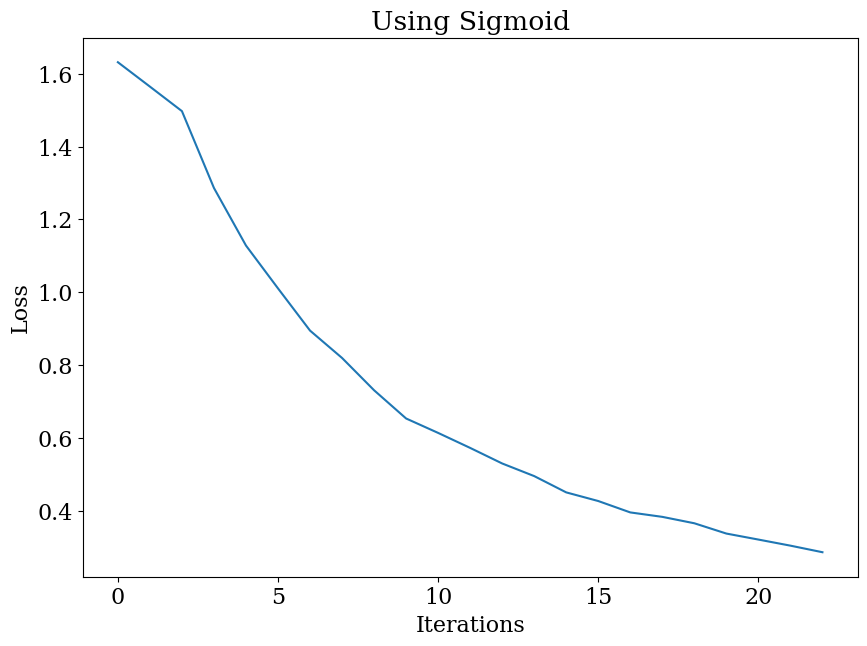

In [30]:
plt.plot(J_sigmoid)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Using Sigmoid")
plt.savefig(os.path.join(SAVE_DIR, '0701.png'))

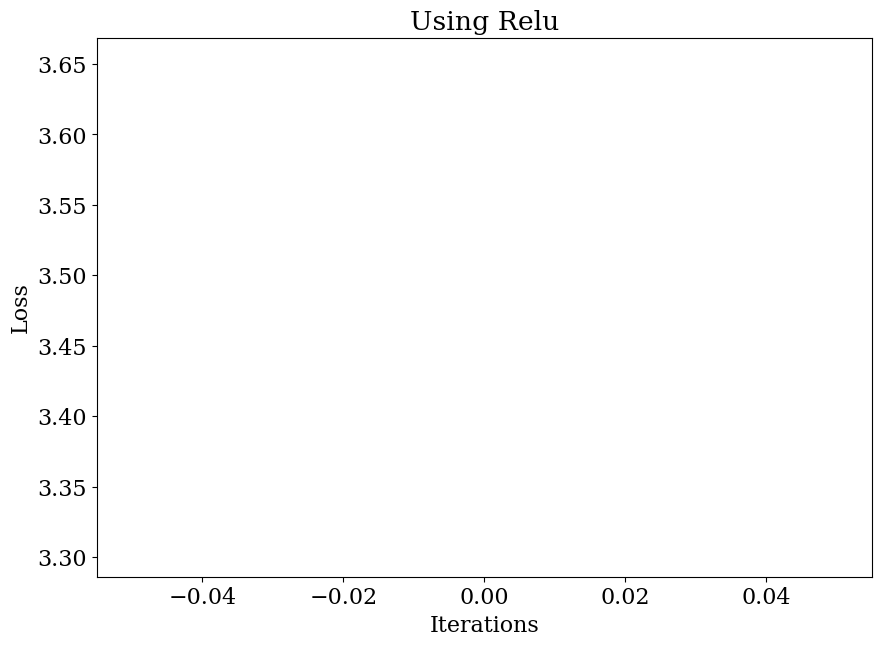

In [31]:
plt.plot(J_relu)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Using Relu")
plt.savefig(os.path.join(SAVE_DIR, '0702.png'))